# News TL;DR using Langgraph (Too Long Didn't Read)

## Overview
This project demonstrates the creation of a news summarization agent uses large language models (LLMs) for decision making and summarization as well as a news API calls. The integration of LangGraph to coordinate sequential and cyclical processes, open-ai to choose and condense articles, newsAPI to retrieve relevant article metadata, and BeautifulSoup for web scraping allows for the generation of relevant current event article TL;DRs from a single query.

## Motivation
Although LLMs demonstrate excellent conversational and educational ability, they lack access to knowledge of current events. This project allow users to ask about a news topic they are interested and receive a TL;DR of relevant articles. The goal is to allow users to conveniently follow their interest and stay current with their connection to world events.

## Key Components
- **LangGraph**: Orchestrates the overall workflow, managing the flow of data between different stages of the process.
- **GPT-4o-mini (via LangChain)**: Generates search terms, selects relevant articles, parses html, provides article summaries
- **NewsAPI**: Retrieves article metadata from keyword search
- **BeautifulSoup**: Retrieves html from page
- **Asyncio**: Allows separate LLM calls to be made concurrently for speed efficiency.

In [1]:
# Here is the setup to install deps

# !pip install langgraph -q
# !pip install langchain-openai -q
# !pip install langchain-core -q
# !pip install pydantic -q
# !pip install python-dotenv -q
# !pip install newsapi-python -q
# !pip install beautifulsoup4 -q
# !pip install ipython -q
# !pip install nest_asyncio -q

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from datetime import datetime
import re

from getpass import getpass
from dotenv import load_dotenv

from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup

from IPython.display import display, Image as IPImage
import asyncio

In [3]:
load_dotenv()

model = 'gpt-4o-mini'
llm = ChatOpenAI(model=model)

In [4]:
newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))

query = 'ai news of the day'

all_articles = newsapi.get_everything(q=query, sources='google-news,bbc-news,techcrunch', domains='techcrunch.com, bbc.co.uk', language='en', sort_by='relevancy',)

all_articles['articles'][0]

{'source': {'id': 'techcrunch', 'name': 'TechCrunch'},
 'author': 'Ivan Mehta',
 'title': 'Opera adds its Aria AI assistant to Opera Mini browser',
 'description': 'Norway-based browser company Opera said today that it is making its AI assistant Aria available to Opera Mini users on Android.\xa0This move will help users with low-end devices and data constraints access better AI features. Aria AI can help users get the lates…',
 'url': 'https://techcrunch.com/2025/04/16/opera-adds-its-aria-ai-assistant-to-opera-mini-browser/',
 'urlToImage': 'https://techcrunch.com/wp-content/uploads/2025/04/Opera-Mini-Aria.png?resize=1200,675',
 'publishedAt': '2025-04-16T08:00:00Z',
 'content': 'Norway-based browser company Opera said today that it is making its AI assistant Aria available to Opera Mini users on Android.\xa0This move will help users with low-end devices and data constraints acc… [+1555 chars]'}

In [5]:
# Alright now we must define the data strcutres here

class GraphState(TypedDict):
    news_query: Annotated[str, 'Input query to extract news search parameters form.']
    num_searches_remaining: Annotated[int, 'Number of articles to search for']
    newsapi_params: Annotated[dict, 'Structured argument for the News API']
    past_searches: Annotated[List[dict], 'List of search params already used']
    articles_metadata: Annotated[list[dict], 'Article metadata response from the news API']
    scraped_urls: Annotated[List[str], 'List of urls already scraped.']
    num_articles_tldr: Annotated[int, "Number of articles to create TTL;DR for."]
    potential_articles: Annotated[List[dict[str, str, str]], 'Article with full text to consider summarizing']
    tldr_articles: Annotated[List[dict[str,str,str]], 'Selected article TL;DRs.']
    formatted_results: Annotated[str, 'Formatted results to display.']

In [6]:
# Now we will define the NewsAPI argument data strucutre using Pydanitc

class NewsApiParams(BaseModel):
    q: str = Field(description="1-3 concise keyword search terms that are not too specific")
    sources: str = Field(description="comma-seperated list of sources fromL 'abc-news,abc-new-au,associated-press,australian-financial-review,axios,bbc-news,bbc-sport,bloomberg,business-insider,cbc-news,cbs-news,cnn,financial-post,fortune'")
    from_param: str = Field(description="date in format 'YYY-MM-DD' Two days ago minimum. Extend up to 30 days on second and subsequent requests.")
    to: str = Field(description="date in format 'YYYY-MM-DD' today's date unless specified")
    language: str = Field(description="language of articles 'en' unless specified one of ['ar', 'de', 'en', 'es', 'fe', 'he', 'it', 'nl', 'no', 'pt', 'ru', 'se', 'ud', 'zh']")
    sort_by: str = Field(description="sort by relevancy', 'popularity', or 'publishedAt")

In [7]:
# Lets define our graph functions

def generate_newsapi_params(state: GraphState) -> GraphState:
    """Based on the query, generate News API params."""
    # initialize parser to define the structure of the response
    parser = JsonOutputParser(pydantic_object=NewsApiParams)

    # retrieve today's date
    today_date = datetime.now().strftime("%Y-%m-%d")

    # retrieve list of past search params
    past_searches = state["past_searches"]

    # retrieve number of searches remaining
    num_searches_remaining = state["num_searches_remaining"]

    # retrieve the user's query
    news_query = state["news_query"]

    template = """
    Today is {today_date}.

    Create a param dict for the News API based on the user query:
    {query}

    These searches have already been made. Loosen the search terms to get more results.
    {past_searches}
    
    Following these formatting instructions:
    {format_instructions}

    Including this one, you have {num_searches_remaining} searches remaining.
    If this is your last search, use all news sources and a 30 days search range.
    """

    # create a prompt template to merge the query, today's date, and the format instructions
    prompt_template = PromptTemplate(
        template=template,
        variables={"today": today_date, "query": news_query, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining},
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    # create prompt chain template
    chain = prompt_template | llm | parser

    # invoke the chain with the news api query
    result = chain.invoke({"query": news_query, "today_date": today_date, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining})

    # update the state
    state["newsapi_params"] = result

    return state



In [9]:
def retrieve_articles_metadata(state: GraphState) -> GraphState:
    """Using the NewsAPI params, perform api call."""
    # parameters generated for the News API
    newsapi_params = state["newsapi_params"]

    # decrement the number of searches remaining
    state['num_searches_remaining'] -= 1

    try:
        # create a NewsApiClient object
        newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))
        
        # retreive the metadata of the new articles
        articles = newsapi.get_everything(**newsapi_params)

        # append this search term to the past searches to avoid duplicates
        state['past_searches'].append(newsapi_params)

        # load urls that have already been returned and scraped
        scraped_urls = state["scraped_urls"]

        # filter out articles that have already been scraped
        new_articles = []
        for article in articles['articles']:
            if article['url'] not in scraped_urls and len(state['potential_articles']) + len(new_articles) < 10:
                new_articles.append(article)

        # reassign new articles to the state
        state["articles_metadata"] = new_articles

    # handle exceptions
    except Exception as e:
        print(f"Error: {e}")

    return state

In [10]:
def retrieve_articles_text(state: GraphState) -> GraphState:
    """Web scrapers to retrieve article tet"""
    # load retireved article metadata
    articles_metatdata = state["articles_metadata"]
    # Add headers to simulate a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
    }

    # create list to store valid article dicts
    potential_articles = []

    # iterate over the urls
    for article in articles_metatdata:
        # etract the article
        url = article["url"]

        # use beutiful soup to etratc the article content
        response = requests.get(url, headers=headers)

        # check if the request was succesful
        if response.status_code == 200:
            # parse the HTMLcontent
            soup = BeautifulSoup(response.content, 'html.parser')

            # find the article content
            text = soup.get_text(strip=True)

            # append the article dict to the processed urls
            potential_articles.append({"title": article["title"], "url": url, "description": article["description"], "text": text})
                        
            # append the processed articles to the state
            state["scraped_urls"].append(url)

    # append the processed articles to the state
    state["potential_articles"].extend(potential_articles)

    return state

In [12]:
def select_top_urls(state: GraphState) -> GraphState:
    """Based on the article synoses, choose the top-n articles to summarize."""
    news_query = state["news_query"]
    num_articles_tldr = state["num_articles_tldr"]

    # load all processed articles with full text but no summaries
    potential_articles = state["potential_articles"]

    # format the metatdat
    formatted_metadata = "\n".join([f"{article['url']}\n{article['description']}\n" for article in potential_articles])

    prompt = f""" 
    Based on the users news query:
    {news_query}

    Reply with a list of strings of up to {num_articles_tldr} relevant urls.
    Don't add any urls that are not relevant or aren't listed specifically.
    {formatted_metadata}
    """
    result = llm.invoke(prompt).content

    # use rege to etract the urls as a list
    url_pattern = r'(https?://[^\s",]+)'

    # fine all URLs in the tet
    urls = re.findall(url_pattern, result)

    # add the selected article metatdata to the state
    tldr_articles = [article for article in potential_articles if article['url'] in urls]

    state["tldr_articles"] = tldr_articles

    return state

In [13]:
async def summarize_articles_parallel(state: GraphState) -> GraphState:
    """Summarize the articles based on full tet."""
    tldr_articles = state["tldr_articles"]

    # prompt = """
    # Summarize the article text in a bulleted tl;dr. Each line should start with a hyphen -
    # {article_text}
    # """

    prompt = """
    Create a * bulleted summarizing tldr for the article:
    {text}
      
    Be sure to follow the following format exaxtly with nothing else:
    {title}
    {url}
    * tl;dr bulleted summary
    * use bullet points for each sentence
    """

    # iterate iover the selected articles and collect summaries synchronously
    for i in range(len(tldr_articles)):
        text = tldr_articles[i]["text"]
        title = tldr_articles[i]["title"]
        url = tldr_articles[i]["url"]
        # invoke the llm synchronously
        result = llm.invoke(prompt.format(title=title, url=url, text=text))
        tldr_articles[i]["summary"] = result.content

    state["tldr_articles"] = tldr_articles

    return state

In [15]:
def format_results(state: GraphState) -> GraphState:
    """Format the results for displays."""
    # load a list of past search queries
    q = [newsapi_params["q"] for newsapi_params in state["past_searches"]]
    formatted_results = f"Here are the top {len(state['tldr_articles'])} articles based on search terms:\n{', '.join(q)}\n\n"

    # load the summarized articles
    tldr_articles = state["tldr_articles"]

    # format article tl;dr summaries
    tldr_articles = "\n\n".join([f"{article['summary']}" for article in tldr_articles])

    # concatenate summaries to the formatted results
    formatted_results += tldr_articles

    state["formatted_results"] = formatted_results

    return state

In [16]:
def articles_text_decision(state: GraphState) -> GraphState:
    """Chekc results of retrieve_articles_text to determine next step."""
    if state["num_searches_remaining"] == 0:
        # if no articles with text were found return END
        if len(state['potential_articles']) == 0:
            state["formatted_results"] = "No articles with text found."
            return "END"
        # if some articles were found, move on to selcting the top urls
        else:
            return "select_top_urls"
    else:
        # if the number of articles found is less than the number of articles to summarize, continue searching
        if len(state["potential_articles"]) < state["num_articles_tldr"]:
            return "generate_newsapi_params"
        # otherwise move on to selecting the top urls
        else:
            return "select_top_urls"

In [19]:
workflow = Graph()

workflow.set_entry_point("generate_newsapi_params")

workflow.add_node("generate_newsapi_params", generate_newsapi_params)
workflow.add_node("retrieve_articles_metadata", retrieve_articles_metadata)
workflow.add_node("retrieve_articles_text", retrieve_articles_text)
workflow.add_node("select_top_urls", select_top_urls)
workflow.add_node("summarize_articles_parallel", summarize_articles_parallel)
workflow.add_node("format_results", format_results)
# workflow.add_node("add_commentary", add_commentary)

workflow.add_edge("generate_newsapi_params", "retrieve_articles_metadata")
workflow.add_edge("retrieve_articles_metadata", "retrieve_articles_text")
# if the number of articles with parseable text is less than number requested, the search for mroe articles
workflow.add_conditional_edges(
    "retrieve_articles_text",
    articles_text_decision,
    {
        "generate_newsapi_params": "generate_newsapi_params",
        "select_top_urls": "select_top_urls",
        "END": END
    }
)
workflow.add_edge('select_top_urls', "summarize_articles_parallel")
workflow.add_conditional_edges(
    "summarize_articles_parallel",
    lambda state: "format_results" if len(state["tldr_articles"]) > 0 else "END",
    {
        "format_results": "format_results",
        "END": END,
    }
)
workflow.add_edge("format_results", END)

app = workflow.compile()


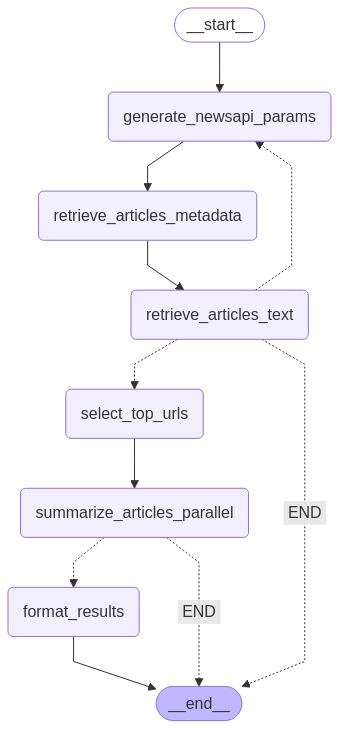

In [21]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [24]:
# THIS IS THE RUNNER
async def run_workflow(query: str, num_searches_remaining: int = 10, num_articles_tldr: int = 3):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "news_query": query,
        "num_searches_remaining": num_searches_remaining,
        "newsapi_params": {},
        "past_searches": [],
        "articles_metadata": [],
        "scraped_urls": [],
        "num_articles_tldr": num_articles_tldr,
        "potential_articles": [],
        "tldr_articles": [],
        "formatted_results": "No articles with text found."
    }
    try:
        result = await app.ainvoke(initial_state)
        
        return result["formatted_results"]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [27]:
# Execute workflow
query = "what are the top genai news of the today?"
print(await run_workflow(query, num_articles_tldr=3))

Here are the top 3 articles based on search terms:
genai news

A ‘Complete Revolution’ in Manufacturing: NTT DATA Research Reveals GenAI’s Transformative Potential and Impact on Core Functions  
https://financialpost.com/pmn/business-wire-news-releases-pmn/a-complete-revolution-in-manufacturing-ntt-data-research-reveals-genais-transformative-potential-and-impact-on-core-functions  
* NTT DATA's research highlights the transformative impact of GenAI on manufacturing.  
* 95% of surveyed manufacturing leaders reported improved efficiency and performance due to GenAI.  
* Integration of Internet of Things (IoT) data into GenAI is expected to enhance AI-generated outputs by 94%.  
* Combining digital twins with GenAI can improve physical asset performance and supply chain resilience, according to 91% of respondents.  
* Major use cases for GenAI include supply chain management, quality control, and process automation.  
* Despite benefits, manufacturers face challenges such as outdated inf